## Описание проекта <br>
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

Импорт библиотек

In [25]:
!pip install --upgrade scikit-learn --quiet

In [26]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor

In [27]:
RANDOM_STATE = 42

### Шаг 1. Загрузка данных

In [28]:
taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [29]:
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [30]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [31]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Приведём datetime к типу данных datetime

In [32]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [33]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Ресемплируем данные по одному часу

In [34]:
taxi = taxi.set_index('datetime').resample('1h').sum()

taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#### Промежуточный вывод <br>
Данные загружены, приведены к типу datetime и ресемплированы по одному часу.

### Шаг 2. Анализ данных

Посмотрим за какой период у нас есть данные

In [35]:
taxi.index.min(), taxi.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

У нас доступны данные за 6 месяцев с марта по август 2018 года (включительно).

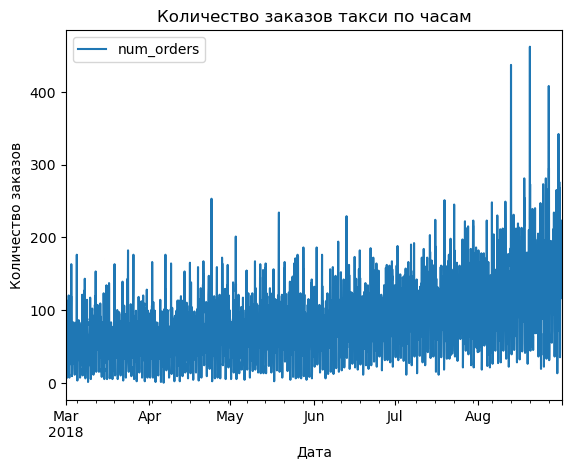

In [36]:
taxi.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси по часам')
plt.show();

In [37]:
decomposed = seasonal_decompose(taxi)

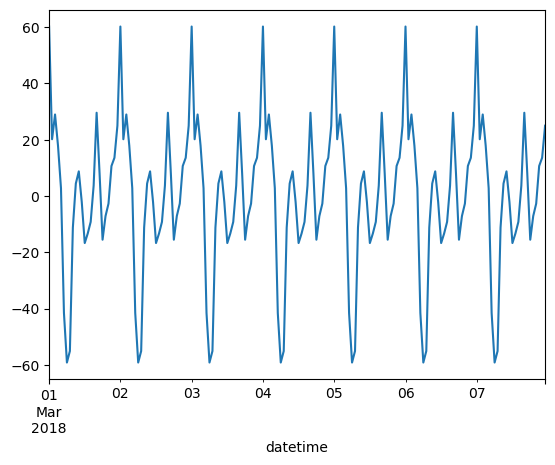

In [38]:
# Сезонность за неделю
decomposed.seasonal['2018-03-01':'2018-03-07'].plot();

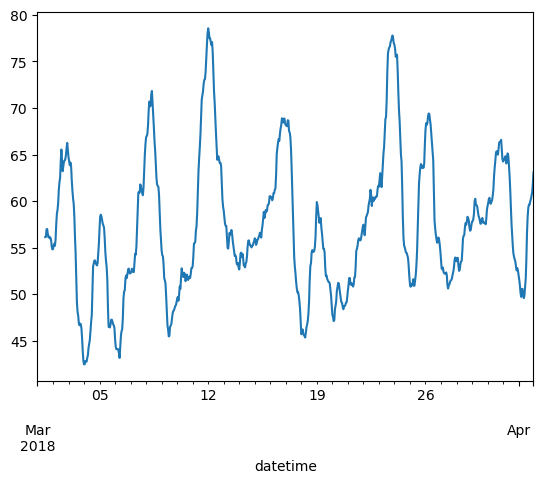

In [39]:
# Тренд за месяц
decomposed.trend['2018-03-01':'2018-04-01'].plot();

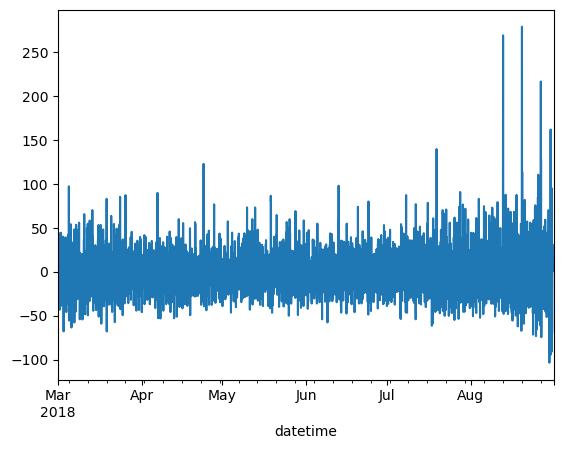

In [40]:
# Остатки
decomposed.resid.plot();

#### Промежуточный вывод <br>
Данные за период с марта по август 2018 года. По графику видно, что количество заказов такси растёт к концу периода. Пики приходятся на дни праздников и время отпусков. Особенно это заметно в конце августа. В течение каждого месяца также видны пики в выходные дни.

### Шаг 3. Обучение моделей и тестирование

In [41]:
# Функция для создания новых признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [42]:
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [43]:
best_rmse = float('inf')
best_params = None

lags = range(1, 100, 5)
rolling_means = range(1, 100, 5)

for max_lag in lags:
    for rolling_mean_size in rolling_means:
        make_features(taxi, max_lag, rolling_mean_size)

        train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

        train = train.dropna()

        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']

        X_test = test.drop('num_orders', axis=1)
        y_test = test['num_orders']

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse_lr = rmse(y_test, y_pred)

        # Проверяем, является ли текущий RMSE лучшим
        if rmse_lr < best_rmse:
            best_rmse = rmse_lr
            best_params = {'max_lag': max_lag, 'rolling_mean_size': rolling_mean_size}

# Выводим лучший результат
print(f"Лучший RMSE: {best_rmse}")
print(f"Параметры: {best_params}")

/var/folders/38/zll4hxn94739278yzc2l5hl40000gn/T/ipykernel_3310/2161150389.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/38/zll4hxn94739278yzc2l5hl40000gn/T/ipykernel_3310/2161150389.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)


Лучший RMSE: 41.53609702276561
Параметры: {'max_lag': 96, 'rolling_mean_size': 46}


Применим лучшие параметры для создания новых признаков

In [44]:
make_features(taxi, best_params['max_lag'], best_params['rolling_mean_size'])

In [45]:
# Разделим данные на обучающую и тестовую выборки
train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

train = train.dropna()

In [46]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

#### Линейная регрессия

In [47]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse_lr = rmse(y_test, y_pred)

print(f'RMSE линейной регрессии: {rmse_lr}')

RMSE линейной регрессии: 41.53609702276561


RMSE линейной регрессии: 41.5 < 48 - условие задачи выполнено

#### Случайный лес

In [48]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse_rf = rmse(y_test, y_pred)

print(f'RMSE случайного леса: {rmse_rf}')

RMSE случайного леса: 40.99545453779213


RMSE случайного леса: 41 < 48 - условие задачи выполнено. Случайный лес также показал результат лучше, чем линейная регрессия. Также можно можно попробовать подобрать гиперпараметры для случайного леса и улучшить результат

#### XGBoost (градиентный бустинг)

In [49]:
model = XGBRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse_xgb = rmse(y_test, y_pred)

print(f'RMSE XGBoost: {rmse_xgb}')

RMSE XGBoost: 40.21496553267477


RMSE XGBoost: 40.2 < 48 - условие задачи выполнено. XGBoost также показал результат лучше, чем линейная регрессия и случайный лес

### Общий вывод <br>
В ходе выполнения проекта были выполнены следующие шаги:
1. Загружены и проанализированы данные.
2. Данные ресемплированы по одному часу.
3. Обучены модели линейной регрессии, случайного леса и XGBoost.

<br>
Лучший результат показала модель XGBoost с RMSE 40.2 на тестовой выборке. Это значение меньше 48, что соответствует условиям задачи. Можно попробовать улучшить результат, подобрав гиперпараметры для моделей или добавив новые признаки.